# Setup

In [1]:
#from glove import Corpus, Glove

import numpy as np

#from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='philsophie', api_key='BluoHvhy1CNCccyCOycW')

import gensim
from gensim.parsing.preprocessing import remove_stopwords

from scipy import spatial

# Read files

In [2]:
embeddings_index = {}
glove_file = './glove.6B/glove.6B.300d.txt'

with open(glove_file, "r", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [3]:
#print(embeddings_index['abundance'])

In [17]:
with open("values.txt", "r", encoding='utf-8') as fin:
    values = fin.readlines()

values = [x.strip().lower() for x in values] 
len(values)

483

In [6]:
texts = []
with open("titles.txt", "r", encoding='utf-8') as fin:
    for line in fin:
        line = remove_stopwords(line)
        texts.append(gensim.utils.simple_preprocess(line))

len(texts)

48

In [3]:
texts = []
with open("./Tweepy/twitter_ethics_text", "r", encoding='utf-8') as fin:
    twitter_ethics = eval(fin.read())
    for line in twitter_ethics:
        line = remove_stopwords(line)
        texts.append(gensim.utils.simple_preprocess(line))

len(texts)

307

In [11]:
for text in texts:
    for word in text:
        if(word=="https"):
            text.remove(word)
        elif(word=="co"):
            text.remove(word)

In [4]:
print(texts)

[['how', 'th', 'century', 'fox', 'uses', 'ml', 'predict', 'movie', 'audience', 'google', 'cloud', 'blog'], ['facebook', 'clear', 'history', 'tool', 'actually', 'happen', 'it', 'time'], ['why', 'mass', 'data', 'fragmentation', 'matters', 'compare', 'cloud'], ['opinion', 'the', 'two', 'codes', 'your', 'kids', 'need', 'know', 'the', 'new', 'york', 'times'], ['bloomberg', 'are', 'robot'], ['samsung', 'announces', 'new', 'galaxy', 'plus', 'phones', 'business', 'insider'], ['silicon', 'valley', 'oversight', 'democrats', 'probe', 'tech', 'privacy', 'practices', 'the', 'washington', 'post'], ['facebook', 'cryptocurrency', 'whatsapp', 'launch', 'half', 'report', 'business', 'insider'], ['sophie', 'thiebaut', 'linkedin', 'wil', 'je', 'meer', 'weten', 'ubo', 'en', 'digitaal', 'schrijf', 'je', 'voor', 'het', 'webinar', 'van', 'corporify'], ['tolkien', 'official', 'trailer', 'fox', 'searchlight', 'youtube'], ['new', 'flaws', 'allow', 'attackers', 'intercept', 'calls', 'track', 'phone', 'locations',

# Helper functions

In [5]:
def plotplotly(X, y, text=False):
    mode = 'markers'
    if text:
        mode = 'markers+text'
        
    data = [
    go.Scatter(
        x=X[:, 0],
        y=X[:, 1],
        mode=mode,
        text=y
        )
    ]

    layout = go.Layout(title='Hover over the points to see the text')

    fig = go.Figure(data=data, layout=layout)
    return fig

In [6]:
def hashdictkey(key):
    return str(list(key))

In [7]:
def unhashdictkey(key, asnparray=True):
    if asnparray:
        return np.array(eval(key))
    return eval(key)

In [8]:
def getDistance(list1, list2):
    return spatial.distance.cosine(list1, list2)

In [9]:
def compileMatrix(comparelist):
    """
    Given a list of vectors, this method returns a matrix of pairwise comparison calculations of distances
    :param tree_list: list of trees in bracket notation
    :return: matrix of pairwise comparisons using distance
    """

    print("# comparelist:", len(comparelist))

    n = len(comparelist)
    print("# n: ", n)
    disMatrix = [x[:] for x in [[0] * n] * n]
    #threshold = 0.32

    for i in range(n - 1):
        for j in range(i + 1, n):
            list1 = comparelist[i]
            list2 = comparelist[j]

            # thresholds
            
            # distance
            dis = getDistance(list1, list2)

            # update matrix
            disMatrix[i][j] = disMatrix[j][i] = dis
    
    return disMatrix

In [10]:
def embcomb(embs, words, min_comb=2, max_comb=3):
    emb_comb = []
    word_comb = []
    if len(embs) < min_comb:
        return None
    for i in range(len(embs)+1):
        for j in range(i+2, min(len(embs)+1, i+max_comb+1)):
            #print(i, j)
            #print(embs[i:j,:])
            #print(y[i:j])
            ec = np.mean((embs[i:j,:]), axis=0)
            emb_comb.append(ec)
            word_comb.append(set(y[i:j]))
    return [emb_comb, word_comb]

In [11]:
def thresholdMatrix(disMatrix, threshold=0.2, num_threshold=4):
    """
    Given a matrix, method returns which rows indexes have columns less than a certain threshold at least a certain number of times
    :param disMatrix: a matrix of distances
    :param threshold: the columns in a row to be thresholded
    :param num_threshold: the number of columns with a certain threshold
    :return: vector of row indexes
    """

    print("# disMatrix:", len(disMatrix))

    n = len(disMatrix)
    print("# n ", n)
    
    disThresholded = []
    for i in range(n - 1):
        cnt = 0
        for j in range(i + 1, n):

            # distance
            dis = disMatrix[i][j]
            
            if dis < threshold:
                cnt += 1
                
        disThresholded.append(cnt)
    
    idxs = [i for i, cnt in enumerate(disThresholded) if cnt >= num_threshold]
    
    return idxs

# Values vec

In [18]:
X = np.array([embeddings_index[x] for x in values if x in embeddings_index])
y = np.array([x for x in values if x in embeddings_index])
len(X)

455

In [19]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X)

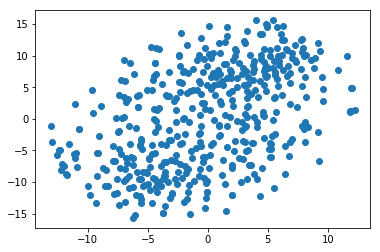

In [20]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [26]:
fig = plotplotly(X_embedded, y, text=True)
py.iplot(fig, filename='hover-chart-basic')

# Title vec (average words)

In [29]:
X = []
for title in texts:
    vec = None
    for word in title:
        if word in embeddings_index:
            if vec is None:
                vec = np.array([embeddings_index[word]])
            else:
                next_vec = embeddings_index[word]
                vec = np.concatenate((vec, np.array([next_vec])), axis=0) 
    
    vec = vec.mean(axis=0)
    X.append(vec)
    
y = ['-'.join(t) for t in texts]
print(len(y))
print(len(X))

48
48


In [30]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X)

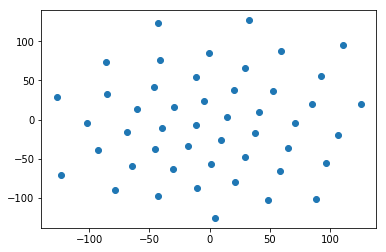

In [31]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [32]:
fig = plotplotly(X_embedded, y, text=True)
py.iplot(fig, filename='hover-chart-basic')

# Title vec (title per word)

In [33]:
X = []
y = []
for title in texts:
    t = '-'.join(title)
    vec = None
    for word in title:
        if word in embeddings_index:
            X.append(embeddings_index[word])
            y.append(t)
    
print(len(X))
print(len(y))

276
276


In [34]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X)

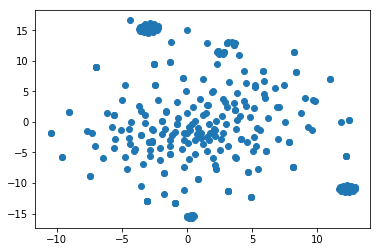

In [35]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [36]:
fig = plotplotly(X_embedded, y)
py.iplot(fig, filename='hover-chart-basic')

# Title vec (word combinations)

In [54]:
embs = np.array([np.array([1,2]), np.array([3,4]), np.array([5,6]), np.array([0,0]), np.array([0,0])])
y = np.array(["this", "is", "fun", "indeed", "yay"])

In [55]:
print(embs)

[[1 2]
 [3 4]
 [5 6]
 [0 0]
 [0 0]]


In [56]:
print(embcomb(embs, y))

0 2
[[1 2]
 [3 4]]
['this' 'is']
0 3
[[1 2]
 [3 4]
 [5 6]]
['this' 'is' 'fun']
1 3
[[3 4]
 [5 6]]
['is' 'fun']
1 4
[[3 4]
 [5 6]
 [0 0]]
['is' 'fun' 'indeed']
2 4
[[5 6]
 [0 0]]
['fun' 'indeed']
2 5
[[5 6]
 [0 0]
 [0 0]]
['fun' 'indeed' 'yay']
3 5
[[0 0]
 [0 0]]
['indeed' 'yay']
([array([2., 3.]), array([3., 4.]), array([4., 5.]), array([2.66666667, 3.33333333]), array([2.5, 3. ]), array([1.66666667, 2.        ]), array([0., 0.])], [{'is', 'this'}, {'fun', 'is', 'this'}, {'fun', 'is'}, {'fun', 'indeed', 'is'}, {'fun', 'indeed'}, {'fun', 'indeed', 'yay'}, {'indeed', 'yay'}])


In [12]:
emb_to_wordcomb = dict()
for title in texts:
    t = '-'.join(title)
    X = []
    y = []
    for word in title:
        # get word embeddings for title
        if word in embeddings_index:
            X.append(embeddings_index[word])
            y.append(word)
        
    # get word combinations of embeddings
    res = embcomb(np.array(X), y)
    if res:
        emb, wordcomb = res
        for i, e in enumerate(emb):
            e = hashdictkey(e)
            emb_to_wordcomb[e] = wordcomb[i]
        
print(len(emb_to_wordcomb))

3464


In [90]:
# test eval of emb
for emb, words in emb_to_wordcomb.items():
    emb = unhashdictkey(emb)
    print(emb[0:5])
    break

[ 0.442895   -0.10741499  0.1282518  -0.15527499 -0.1082345 ]


In [13]:
# compute similar matrix of emb
emb_list = list(emb_to_wordcomb.keys())
emb_list = [unhashdictkey(e) for e in emb_list]
len(emb_list)

3464

In [14]:
disMatrix = compileMatrix(emb_list)
len(disMatrix)

# comparelist: 3464
# n:  3464


3464

In [15]:
# for each emb, get number of other emb with less than a certain threshold
index_threshold = thresholdMatrix(disMatrix)
len(index_threshold)

# disMatrix: 3464
# n  3464


237

In [16]:
# compile list of embeddings and word combinations based on indexes
X = []
y = []
for i in index_threshold:
    emb = emb_list[i]
    embhash = hashdictkey(emb)
    wordcomb = emb_to_wordcomb[embhash]
    wordcomb = '-'.join(list(wordcomb))
    X.append(emb)
    y.append(wordcomb)

print(len(X))
print(len(y))

237
237


In [17]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X)

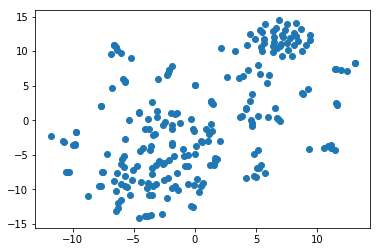

In [18]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [20]:
fig = plotplotly(X_embedded, y, text=False)
py.iplot(fig, filename='hover-chart-basic')

# Twitter Title vec (word comb)

In [ ]:
all_texts = texts

In [27]:
texts = all_texts
len(texts)

6897

In [30]:
import random

random.shuffle(texts)
texts = texts[:500]

In [31]:
emb_to_wordcomb = dict()
for title in texts:
    t = '-'.join(title)
    X = []
    y = []
    for word in title:
        # get word embeddings for title
        if word in embeddings_index:
            X.append(embeddings_index[word])
            y.append(word)
        
    # get word combinations of embeddings
    res = embcomb(np.array(X), y, max_comb=2)
    if res:
        emb, wordcomb = res
        for i, e in enumerate(emb):
            e = hashdictkey(e)
            emb_to_wordcomb[e] = wordcomb[i]
        
print(len(emb_to_wordcomb))

3527


In [32]:
# compute similar matrix of emb
emb_list = list(emb_to_wordcomb.keys())
emb_list = [unhashdictkey(e) for e in emb_list]
len(emb_list)

3527

In [33]:
disMatrix = compileMatrix(emb_list)
len(disMatrix)

# comparelist: 3527
# n:  3527


3527

In [35]:
# for each emb, get number of other emb with less than a certain threshold
index_threshold = thresholdMatrix(disMatrix)
len(index_threshold)

# disMatrix: 3527
# n  3527


242

In [36]:
# compile list of embeddings and word combinations based on indexes
X = []
y = []
for i in index_threshold:
    emb = emb_list[i]
    embhash = hashdictkey(emb)
    wordcomb = emb_to_wordcomb[embhash]
    wordcomb = '-'.join(list(wordcomb))
    X.append(emb)
    y.append(wordcomb)

print(len(X))
print(len(y))

242
242


In [37]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X)

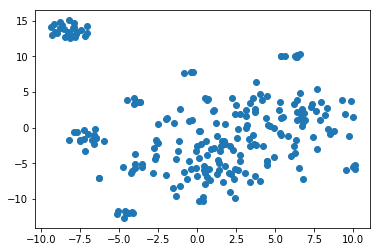

In [38]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [40]:
fig = plotplotly(X_embedded, y, text=False)
py.iplot(fig, filename='hover-chart-basic')

# Gensim most similar

In [1]:
from gensim.models import word2vec

In [ ]:
model = word2vec.Word2Vec(sentences, size=200)
sentences = word2vec.Text8Corpus('text8')

In [2]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath("/home/sophie/AI-Values/glove.6B/glove.6B.300d.txt")
tmp_file = get_tmpfile("/home/sophie/AI-Values/glove.6B/glove.6B.300d_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

In [33]:
print(model.most_similar(['privacy']))

[('confidentiality', 0.5798313617706299), ('liberties', 0.5725791454315186), ('protections', 0.5712763667106628), ('protection', 0.4882546663284302), ('protect', 0.48595649003982544), ('protecting', 0.48228394985198975), ('freedom', 0.460526704788208), ('disclosure', 0.44946324825286865), ('safety', 0.44887790083885193), ('concerns', 0.446600079536438)]


In [36]:
print(model.most_similar(positive=['artificial', 'intelligence'], topn=3))

[('knowledge', 0.4611586332321167), ('information', 0.460480272769928), ('cia', 0.4384228587150574)]


In [37]:
print(model.most_similar(['artificial']))

[('synthetic', 0.49244236946105957), ('insemination', 0.47381332516670227), ('man-made', 0.45914873480796814), ('natural', 0.4262947142124176), ('sweeteners', 0.42168718576431274), ('artificially', 0.41367924213409424), ('implanted', 0.4032576084136963), ('manmade', 0.391124427318573), ('neural', 0.389220654964447), ('sweetener', 0.38666772842407227)]


In [40]:
print(model.most_similar(['artificial', 'intelligence']))

[('knowledge', 0.4611586332321167), ('information', 0.460480272769928), ('cia', 0.4384228587150574), ('methods', 0.4249553978443146), ('techniques', 0.4159538149833679), ('source', 0.41385820508003235), ('sophisticated', 0.4133008122444153), ('secret', 0.41233497858047485), ('using', 0.4104449450969696), ('sources', 0.40984243154525757)]


In [3]:
print(model.most_similar(['genealogy']))

[('genealogical', 0.6413923501968384), ('genealogies', 0.5469214916229248), ('heraldry', 0.4801636338233948), ('ancestry', 0.4725051522254944), ('lineage', 0.46874651312828064), ('ancestor', 0.43732717633247375), ('genealogist', 0.4359472990036011), ('folklore', 0.4338807463645935), ('origins', 0.4301758408546448), ('tracing', 0.41735735535621643)]


In [4]:
print(model.most_similar(['lineage']))

[('lineages', 0.7093613743782043), ('ancestor', 0.6329213380813599), ('descendant', 0.5997883081436157), ('ancestors', 0.5798022150993347), ('ancestry', 0.5490856170654297), ('descendants', 0.5397379398345947), ('origins', 0.5340539813041687), ('bloodline', 0.5154845714569092), ('patrilineal', 0.5056362152099609), ('paternal', 0.5042784214019775)]


In [5]:
print(model.most_similar(['resolve']))

[('resolving', 0.7659726142883301), ('resolved', 0.7524896264076233), ('solve', 0.7424017786979675), ('dispute', 0.6705842018127441), ('disputes', 0.6687039136886597), ('impasse', 0.6213710308074951), ('determination', 0.5951550006866455), ('differences', 0.5740435123443604), ('issue', 0.5731443166732788), ('disagreements', 0.5667888522148132)]


In [6]:
print(model.most_similar(['conflict']))

[('conflicts', 0.8084380626678467), ('war', 0.6729421615600586), ('strife', 0.6499618291854858), ('bloodshed', 0.6260631084442139), ('violence', 0.6070914268493652), ('hostilities', 0.6060783267021179), ('tensions', 0.5968263745307922), ('confrontation', 0.5958433151245117), ('crisis', 0.594000518321991), ('fighting', 0.5881012678146362)]
